In [ ]:
!pip install -q transformers==4.37.2 --quiet
!pip install pydot --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 32.2 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel, AutoTokenizer, AutoModel
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/Colab Notebooks/w266_project')


Mounted at /content/drive


In [ ]:
df = pd.read_csv(f"/content/drive/My Drive/Colab Notebooks/w266_project/join_df.csv", header = 0, sep="\t", index_col=0)

In [ ]:
# Test/train split
X = np.vstack(df['Abstract'])
y = df['JIF']
train_texts, valid_texts, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=42)
valid_labels = np.array(test_labels)
train_labels = np.array(train_labels)

In [ ]:
# Load SciBERT tokenizer and model
model_checkpoint = "allenai/scibert_scivocab_uncased"
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint, from_pt=True)

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model f

In [ ]:
max_length = 400
train_encodings = bert_tokenizer(list(train_texts[:,0]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(list(valid_texts[:,0]), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
def create_bert_regression_model(checkpoint = bert_model,
                                 hidden_size = 50,
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    ### YOUR CODE HERE
    bert_model.trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(cls_token)
    hidden1 = tf.keras.layers.Dropout(dropout)(hidden1)

    hidden2 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer2')(hidden1)
    hidden2 = tf.keras.layers.Dropout(dropout)(hidden2)

    regression = tf.keras.layers.Dense(1, activation='linear', name='regression_layer')(hidden2)

    regression_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[regression])

    regression_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.mean_squared_error,
                                 metrics= [tf.keras.metrics.mean_squared_error])
    ### END YOUR CODE
    return regression_model

In [ ]:
regression_bert_model = create_bert_regression_model(checkpoint=bert_model, hidden_size = 768, dropout=0.2)

In [ ]:
regression_bert_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 400)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 400)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 400)]                0         []                            
 tLayer)                                                                                    

In [ ]:
bert_model_history = regression_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                  valid_labels),
                                                  batch_size=8,
                                                  epochs=20)

Epoch 1/20
403/403 [==============================] - 219s 506ms/step - loss: 6.8824 - mean_squared_error: 6.8824 - val_loss: 3.8803 - val_mean_squared_error: 3.8803
Epoch 2/20
403/403 [==============================] - 164s 406ms/step - loss: 5.9229 - mean_squared_error: 5.9229 - val_loss: 4.0049 - val_mean_squared_error: 4.0049
Epoch 3/20
403/403 [==============================] - 200s 497ms/step - loss: 5.6805 - mean_squared_error: 5.6805 - val_loss: 3.7857 - val_mean_squared_error: 3.7857
Epoch 4/20
403/403 [==============================] - 200s 497ms/step - loss: 5.5823 - mean_squared_error: 5.5823 - val_loss: 3.7824 - val_mean_squared_error: 3.7824
Epoch 5/20
403/403 [==============================] - 163s 406ms/step - loss: 5.3832 - mean_squared_error: 5.3832 - val_loss: 3.8699 - val_mean_squared_error: 3.8699
Epoch 6/20
403/403 [==============================] - 163s 406ms/step - loss: 5.2734 - mean_squared_error: 5.2734 - val_loss: 4.0740 - val_mean_squared_error: 4.0740
Epoc

In [ ]:
regression_bert_model.save("/content/drive/My Drive/Colab Notebooks/w266_project/sciBERT_regressor")

In [ ]:
predictions = regression_bert_model.predict([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask])

44/44 [==============================] - 48s 1s/step


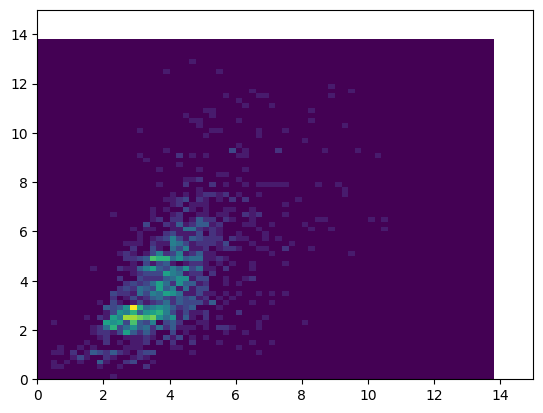

In [ ]:
predictions = predictions.reshape((-1))
fig, ax = plt.subplots()
ax.hist2d(predictions, valid_labels, bins=(np.arange(0, 14, 0.2), np.arange(0, 14, 0.2)))
ax.set_ylim(0,15)
ax.set_xlim(0,15)
plt.show()

In [ ]:
np.corrcoef(predictions, valid_labels)

array([[1.        , 0.56872774],
       [0.56872774, 1.        ]])